# Author Classification

We study the following case: a corpus of sentences belonging respectively to J. Chirac and F. Mitterrand is available (with associated tags). The goal is to build a model that correctly predicts who owns the different sentences.

http://www-connex.lip6.fr/~guigue/wikihomepage/uploads/Course/AFDpresidentutf8.zip

In [1]:
import random
import unicodedata
import numpy as np

from itertools import groupby

import matplotlib.pyplot as plt

import xgboost as xgb #not really usefull as it didn't improve anything !!! :(

import sklearn

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC #too slow to be used !!
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import MiniBatchSparsePCA, PCA
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
f = open("../corpus.tache1.learn.utf8", 'r')
L = f.readlines()
f.close()

In [3]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').replace('\n', '')

L = list(map(strip_accents, L))

In [4]:
def labelize(txt):
    i = txt.index('> ')
    return txt[:i][-1], txt[i+2:]

data = list(map(labelize, L))

In [5]:
data[0]

('C',
 "Quand je dis chers amis, il ne s'agit pas la d'une formule diplomatique, mais de l'expression de ce que je ressens.")

In [6]:
f = open("../corpus.tache1.test.utf8", 'r')
L = f.readlines()
f.close()
L = list(map(strip_accents, L))
data_submission = list(map(labelize, L))
x_submission = list(zip(*data_submission))[1]
#txt_test = ' '.join(x_submission)
#txt_test[:100]
x_submission[0]

"En repondant a votre invitation, en effectuant cette premiere visite d'Etat d'un President francais en Algerie depuis l'independance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitie et de la solidarite."

In [7]:
C = list(filter(lambda c: c[0] == 'C', data))
M = list(filter(lambda c: c[0] == 'M', data))

In [8]:
#random.shuffle(C) #not shufflung now ??!!
#random.shuffle(M)

In [9]:
min_ln = min(len(M), len(C)) #to rebalance
min_ln

7523

In [10]:
data_train = C[:int(min_ln * .8)] + M[:int(min_ln * .8)]
data_test  = C[int(min_ln * .8):min_ln] + M[int(min_ln * .8):min_ln]

In [11]:
random.shuffle(data_train)
random.shuffle(data_test)

## Base Line : char based

In [12]:
def bag_of_char(txt):
    out = np.array([0 for i in range(27)])
    for c in txt:
        if c == ' ':
            out[-1] += 1
        else:
            v = ord(c.lower()) - 97
            if v >= 0 and v <= 26:
                out[v] += 1
    return out / (out.sum() + 1)

bag_of_char(data_train[0][1])

array([0.06040268, 0.00671141, 0.03355705, 0.03355705, 0.15436242,
       0.00671141, 0.00671141, 0.00671141, 0.08053691, 0.        ,
       0.        , 0.04697987, 0.00671141, 0.06711409, 0.04026846,
       0.02013423, 0.00671141, 0.05369128, 0.11409396, 0.06711409,
       0.02013423, 0.02013423, 0.        , 0.        , 0.        ,
       0.        , 0.1409396 ])

In [13]:
x_train = list(map(lambda c: bag_of_char(c[1]), data_train))
x_test  = list(map(lambda c: bag_of_char(c[1]), data_test))

y_train = list(map(lambda c: int(c[0] == 'C'), data_train))
y_test  = list(map(lambda c: int(c[0] == 'C'), data_test))

### Test Random Forest

In [14]:
clf = RandomForestClassifier(n_estimators=700, n_jobs=-1)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
(clf.predict(x_test) == y_test).mean(), f1_score(y_test, clf.predict(x_test))

(0.6169435215946844, 0.6014517801590045)

### Test XGBoost

In [16]:
#y_train_xgb = np.array(list(map(lambda y: [1, 0] if y else [0, 1], y_train)))
#y_test_xgb  = np.array(list(map(lambda y: [1, 0] if y else [0, 1], y_test)))

In [17]:
clf = xgb.XGBClassifier(
    max_depth=10,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='error',
    #learning_rate=0.001
)
clf.fit(np.array(x_train), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='error', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [18]:
(clf.predict(x_test) == y_test).mean()

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6013289036544851

## Test simple Logistic Regression

In [19]:
clf = LogisticRegression()
clf.fit(x_train, y_train)
(clf.predict(x_test) == y_test).mean()

0.5983388704318937

## Try another way to encode text

### Count Words encoding

In [20]:
# Count Words encoding
count_vect = CountVectorizer()#ngram_range=(1, 2))#, max_features=100000) #remove bigrams & max_features ??!!
x_submission_counts = count_vect.fit_transform(x_submission) #only use words which are present in the final testing set
x_train_counts = count_vect.transform(list(map(lambda c: c[1], data_train)))
x_test_counts  = count_vect.transform(list(map(lambda c: c[1], data_test)))

In [21]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
clf.fit(x_train_counts, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
(clf.predict(x_test_counts) == y_test).mean()

0.7149501661129568

In [23]:
f1_score(y_test, clf.predict(x_test_counts))

0.6995798319327731

### TF-IDF Encoding

In [24]:
# TF-IDF encoding
tfidf_transformer = TfidfTransformer()
x_submission_tfidf = tfidf_transformer.fit_transform(x_submission_counts)
x_train_tfidf = tfidf_transformer.transform(x_train_counts)
x_test_tfidf  = tfidf_transformer.transform(x_test_counts)

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [25]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
clf.fit(x_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
f1_score(y_test, clf.predict(x_test_tfidf))

0.7008605851979346

In [27]:
logistic_clf = LogisticRegression()
logistic_clf.fit(np.array(x_train_tfidf.toarray()), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
f1_score(y_test, logistic_clf.predict(x_test_tfidf.toarray())) #.75

0.7508417508417509

=> In this case the logistic regression seem to perform better than the random forest...

___As the f1\_score of sklearn is an average of the 2 f1\_score of the 2 classes the results are lower on the real leader board___

In [37]:
clf_svm = SGDClassifier(loss='hinge')
clf_svm.fit(np.array(x_train_tfidf.toarray()), y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [38]:
#as it's stochastic restart if no good enought
f1_score(y_test, clf_svm.predict(x_test_tfidf.toarray()))

0.7685723020483032

## Build the submission

In [31]:
out = clf_svm.predict(x_submission_tfidf) #logistic_clf #clf_svm

In [32]:
out = list(map(lambda v: 'C' if v else 'M', out))

In [33]:
''.join(out)[:100]

'CCCMMMMCCCCCMCCCMCCMCCCCMCMCCCCCCCCCCMCCCCCCMCMCCCCMMMCMCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCMCCC'

In [34]:
f = open(str('out') + '.txt', 'w')
f.write(''.join(out))
f.close()

### Make a voting solution from all previous solution

Try to average submission...

Didn't worked so well... :'( some solution alone are better... :(

## Try to predict after unsupervised topic classification

- 20  => NOT WORKING AT ALL !!!
- 100 => not good enought...


It's seem we can't predict who is speaking only by looking his speech topic...

In [ ]:
lda = LatentDirichletAllocation(100, n_jobs=-1)
lda.fit(x_submission_counts)

In [101]:
lda_topics = lda.transform(x_submission_counts)

In [102]:
x_train_lda_topics = lda.transform(x_train_counts)

In [103]:
x_test_lda_topics = lda.transform(x_test_counts)

In [104]:
logistic_lda_clf = LogisticRegression()
logistic_lda_clf.fit(np.array(x_train_lda_topics), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [105]:
f1_score(y_test, logistic_lda_clf.predict(x_test_lda_topics))

0.6273990734612839

In [108]:
out = list(map(lambda v: 'C' if v > .5 else 'M', smooth(logistic_lda_clf.predict(lda_topics), 17)))
f = open(str('out') + '.txt', 'w')
f.write(''.join(out))
f.close()

### Merging LDA output and BoW

In [117]:
x_train_new_features = np.concatenate([x_train_tfidf.toarray(), x_train_lda_topics], 1)
x_test_new_features  = np.concatenate([x_test_tfidf.toarray(),  x_test_lda_topics],  1)
x_submission_new_features = np.concatenate([x_submission_tfidf.toarray(), lda_topics], 1)

In [123]:
bow_lda_clf = RandomForestClassifier(100)
bow_lda_clf.fit(np.array(x_train_new_features), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [124]:
f1_score(y_test, bow_lda_clf.predict(x_test_new_features))

0.648928818244644

## Smooth Results

As we get a __.53__ f1 score we need to find a way to improve it !!

As the dataset is _imbalanced_ and classes are _grouped_, we can smooth the predicted classes with a ___moving window___...

In [35]:
logistic_clf.predict_proba(x_test_tfidf.toarray())

array([[0.46732975, 0.53267025],
       [0.33302118, 0.66697882],
       [0.32621112, 0.67378888],
       ...,
       [0.47477772, 0.52522228],
       [0.77140283, 0.22859717],
       [0.13432633, 0.86567367]])

In [36]:
#reload the training dataset 
real_labels = np.array(list(zip(*data))[0]) == 'C'

In [37]:
#prepare the whole dataset
all_dataset_count = count_vect.transform(list(zip(*data))[1])
all_dataset_tfidf = tfidf_transformer.transform(all_dataset_count)

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [38]:
pred_labels = logistic_clf.predict_proba(all_dataset_tfidf.toarray()).T[1]

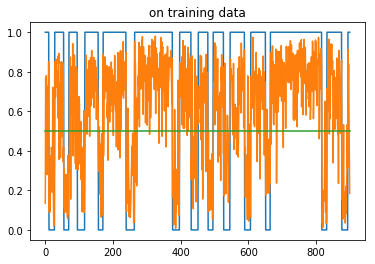

In [44]:
plt.title("on training data")
plt.plot(real_labels[:900])
plt.plot(pred_labels[:900])
plt.plot([.5] * 900)
plt.show()

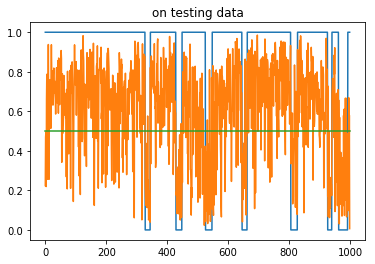

In [45]:
plt.title("on testing data")
plt.plot(real_labels[::-1][:1000])
plt.plot(pred_labels[::-1][:1000])
plt.plot([.5] * 1000)
plt.show()

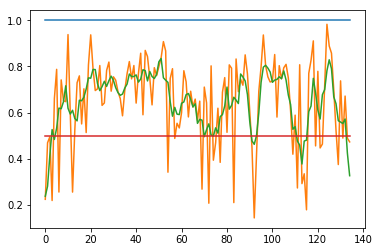

In [62]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(real_labels[::-1][:1000][:135])
plt.plot(pred_labels[::-1][:1000][:135])
plt.plot(smooth(pred_labels[::-1][:1000][:135], 5))
plt.plot([.5] * 135)
plt.show()

In [67]:
pred_submission = logistic_clf.predict_proba(x_submission_tfidf.toarray()).T[1]

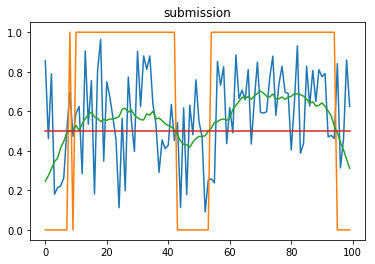

In [80]:
plt.title("submission")
plt.plot(pred_submission[:100])
plt.plot(smooth(pred_submission[:100], 17) > .5)
plt.plot(smooth(pred_submission[:100], 17))
plt.plot([0.5] * 100)

In [208]:
#17 was the best window zize
out = list(map(lambda v: 'C' if v > .5 else 'M',  smooth(pred_submission, 17)))
f = open(str('out') + '.txt', 'w')
f.write(''.join(out))
f.close()

After few tests, a window size of 17 worked the best and improved our score from __.53__ to __.74__ which is a __huge improvment__ ! 

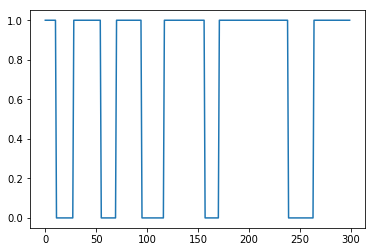

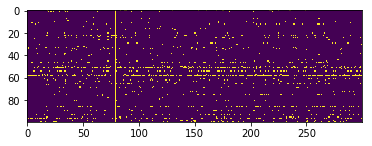

In [143]:
plt.plot(real_labels[:300])
plt.show()
plt.imshow(lda_topics[:300].T > lda_topics[:300].T.std(0))
plt.show()

Adding some simple post processing handcrafted rules to remove still isolated elements...

In [160]:
s = ''.join(out)
s = s.replace("MMCMM", "MMMMM")
s = s.replace("CCMCC", "CCCCC")
s = s.replace("MCM",   "MMM")
s = s.replace("CMC",   "CCC")

s[:100]

'MMMMMMMMMMCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCMMMMMMMMMMMCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'

In [161]:
f = open(str('out') + '.txt', 'w')
f.write(''.join(out))
f.close()

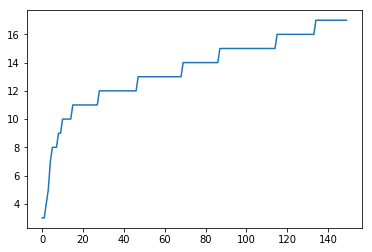

In [172]:
training_labels = ''.join(list(zip(*data))[0])

groups = groupby(training_labels)
result = [(label, sum(1 for _ in group)) for label, group in groups]
m_groups_size = sorted(list(map(lambda c: c[1], filter(lambda c: c[0] == 'M', result))))

plt.plot(m_groups_size[:150])
plt.show()

[]

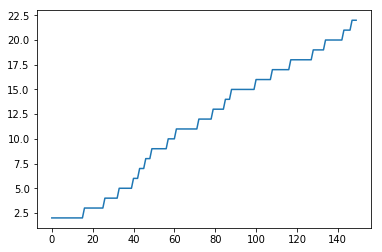

In [182]:
predicted_submission_labels = s #the last submission with the new rules

groups = groupby(predicted_submission_labels)
result = [(label, sum(1 for _ in group)) for label, group in groups]
m_groups_size = sorted(list(map(lambda c: c[1], filter(lambda c: c[0] == 'M', result))))

plt.plot(m_groups_size[:150])
plt.plot()

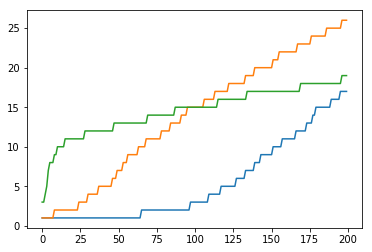

In [204]:
def merge_rules(txt):
    s = ''.join(txt)
    s = s.replace("MMCMM", "MMMMM")
    s = s.replace("CCMCC", "CCCCC")
    s = s.replace("MMCM",   "MMMM")
    s = s.replace("CCMC",   "CCCC")
    #s = s.replace("MMMCCM",  "MMMMMM")
    ##s = s.replace("MMMCCCM", "MMMMMMM")
    return s

def compute_grouping(txt):
    groups = groupby(txt)
    result = [(label, sum(1 for _ in group)) for label, group in groups]
    m_groups_size = sorted(list(map(lambda c: c[1], filter(lambda c: c[0] == 'M', result))))
    return m_groups_size

plt.plot(compute_grouping(out)[:200])
plt.plot(compute_grouping(merge_rules(out))[:200])
plt.plot(compute_grouping(training_labels)[:200])
plt.show()

In [207]:
f = open(str('out') + '.txt', 'w')
f.write(''.join(merge_rules(merge_rules(out))))
f.close()

# Results

- with a simple _Logistic Regression_ on _TF-IDF_ features we could achieve a _.53_ f1_score
- by adding a simple post processing _convolution_ operation to smooth results we go up to _.74_ f1_score
- few post post processing _handcrafted rules_ lead us to ___.749___ f1_score
